### Prototype of integrating TVB with SIIBRA 
#### Download a structural connectivity from SIIBRA and setup a TVB simulation with it

In [21]:
import os
import re
import numpy
import siibra
from tvb.simulator.lab import *

In [22]:
# Add an EBRAINS token
os.environ['HBP_AUTH_TOKEN'] = ''

In [23]:
# Function to choose the SC matrices we need
def get_connectivity_matrices(connectivities):
    # Will be possible to differentiate between structural and functional connectivities
    conn_weights = None
    conn_tracts = None
    for conn in connectivities:
        if 'Averaged_SC_JuBrain_246Regions_HCP_10M_count_MEAN' in conn.name:
            conn_weights = conn
            
        if 'Averaged_SC_JuBrain_246Regions_HCP_10M_length_MEAN' in conn.name:
            conn_tracts = conn
    return conn_weights, conn_tracts


# Function to extract the region positions (working with siibra 0.1a8, but returning only [0, 0, 0] with siibra dev)
def get_position(position_list, idx):
    region_position = position_list[idx].get('position')
    if region_position is None:
        region_position = [0, 0, 0]
    else:
        # The new centroids will also give us information about the space, so we won't need this dummy transformation
        region_position = [reg_pos / 1000000 for reg_pos in region_position]
    return region_position

In [24]:
atlas = siibra.atlases["human"]
jubrain = atlas.get_parcellation("julich 2.5")

In [25]:
# If I use the jubrain parcellation 2.9 for querying the connectivities, I get a single one as result.
connectivities = siibra.get_features(jubrain, siibra.modalities.ConnectivityMatrix)

conn_weights, conn_tracts = get_connectivity_matrices(connectivities)
reg_labels = conn_weights.regionnames # should be possible to get regions instead of strings

In [26]:
# The regex below is used to parse the region names and extract labels and hemispheres into separate arrays 
# The Region objects will give us the label/hemisphere info separately, we won't need this parsing
regex = '([\w\s.-]+)( \(([\w\s,]+)\))? (left|right|both)?'
p = re.compile(regex)

reg_labels_corrected = list()
reg_names_corrected = list()
hemi_array = list()
reg_positions = list()

for reg_label in reg_labels:
    match_rez = p.match(reg_label)
    if match_rez:
        region_name = match_rez.groups()[0]
        region_hemi = match_rez.groups()[-1]
        
        reg_names_corrected.append(region_name.replace(' ', '_'))
        
        # Code used to get region positions in siibra 0.1a8, centroids are being rewritten in siibra dev version
        # Currently, all regions will have position [0, 0, 0]
        region = atlas.get_region(region_name, jubrain)
        region_position_list = region.attrs.get('children')

        if region_hemi == 'right':
            hemi_array.append(1)
            if len(region_position_list) > 1:
                region_position = get_position(region_position_list, 1)
            else:
                region_position = get_position(region_position_list, 0)
        else:
            hemi_array.append(0)
            region_position = get_position(region_position_list, 0)

        reg_positions.append(region_position)

In [27]:
# Moving info from Siibra into TVB concepts
conn = connectivity.Connectivity()
conn.weights = conn_weights.array
conn.tract_lengths = conn_tracts.array
conn.region_labels = numpy.array(reg_names_corrected)
conn.hemispheres = numpy.array(hemi_array, dtype=numpy.bool)
conn.centres = numpy.array(reg_positions)

conn.configure()
conn

/var/folders/nk/m7m7h8l52jl932hv_zf2rs_40000gn/T/ipykernel_7294/2328090084.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  conn.hemispheres = numpy.array(hemi_array, dtype=numpy.bool)


,value
Number of connections,52126
Number of regions,246
Undirected,True
is None,True
"tract_lengths (connections) [min, median, max]","[0.0090468, 74.347, 229.89]"
"tract_lengths [min, median, max]","[0, 61.0905, 229.89]"
"tract_lengths-non-zero [min, median, max]","[0.0090468, 74.347, 229.89]"
"weights [min, median, max]","[0, 1.5846, 255190]"
weights dtype,float64
weights shape,"(246, 246)"


<IPython.core.display.Javascript object>


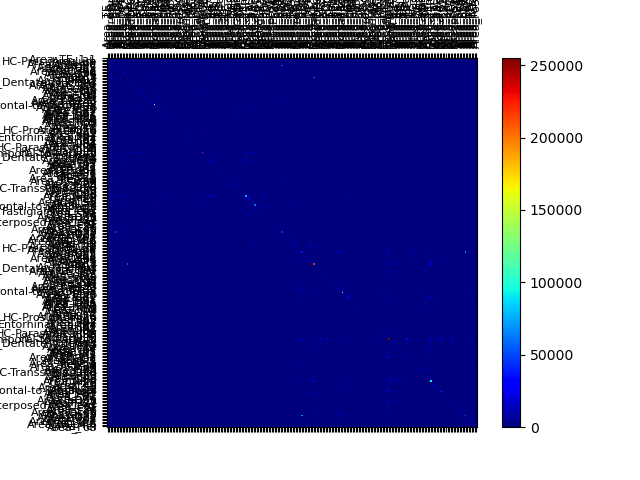

<IPython.core.display.Javascript object>


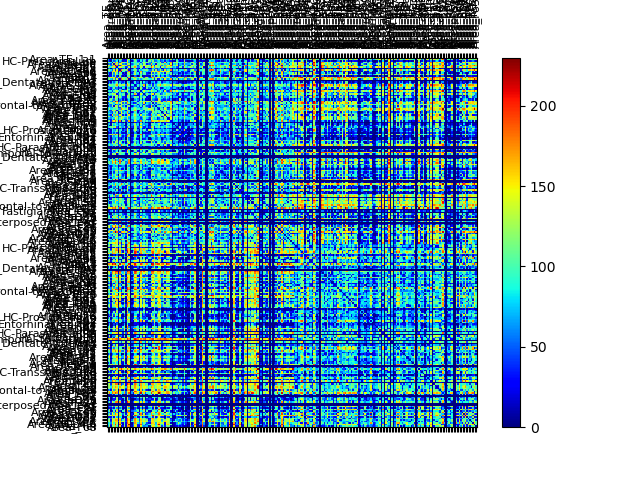

In [28]:
plot_connectivity(connectivity=conn)

In [13]:
# Save connectivity in TVB accepted format
centres_content = numpy.concatenate((numpy.array(reg_names_corrected)[:, None], reg_positions), axis=1)

out_dir = 'julich_conn_pos_altered'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

numpy.savetxt(os.path.join(out_dir, "centers.txt"), centres_content, "%s")
numpy.savetxt(os.path.join(out_dir, "hemispheres.txt"), hemi_array, "%s")
numpy.savetxt(os.path.join(out_dir, "weights.txt"), conn.weights, "%f")
numpy.savetxt(os.path.join(out_dir, "tract_lenghts.txt"), conn.tract_lengths, "%f")

In [14]:
sim = simulator.Simulator()
sim.connectivity = conn
sim.simulation_length = 500
sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 26558bbc-366c-4e6e-ae91-e88f1c8a4800
coupling,Linear gid: c68da807-9ee4-42b7-a0ff-725ef61af35b
gid,UUID('ef42d190-57e7-48c1-8dc4-3e55e5af83e1')
initial_conditions,None
integrator,HeunDeterministic gid: 2c3d32ee-4f5b-4b49-99e1-c4f31b7e2b97
model,Generic2dOscillator gid: 02341613-d601-48e6-9074-8a00bdc97dba
monitors,"(,)"
simulation_length,1000.0


In [15]:
(time, data),  = sim.run()

WARNING  random_state supplied for non-stochastic integration


In [16]:
time.size

1024

In [17]:
data.shape

(1024, 1, 246, 1)

In [18]:
tsr = time_series.TimeSeriesRegion(
    data=data,
    connectivity=sim.connectivity,
    sample_period=sim.monitors[0].period)
tsr.configure()

Populating the interactive namespace from numpy and matplotlib


/Users/pipeline/anaconda/anaconda3/envs/tvb38siibra/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


<IPython.core.display.Javascript object>


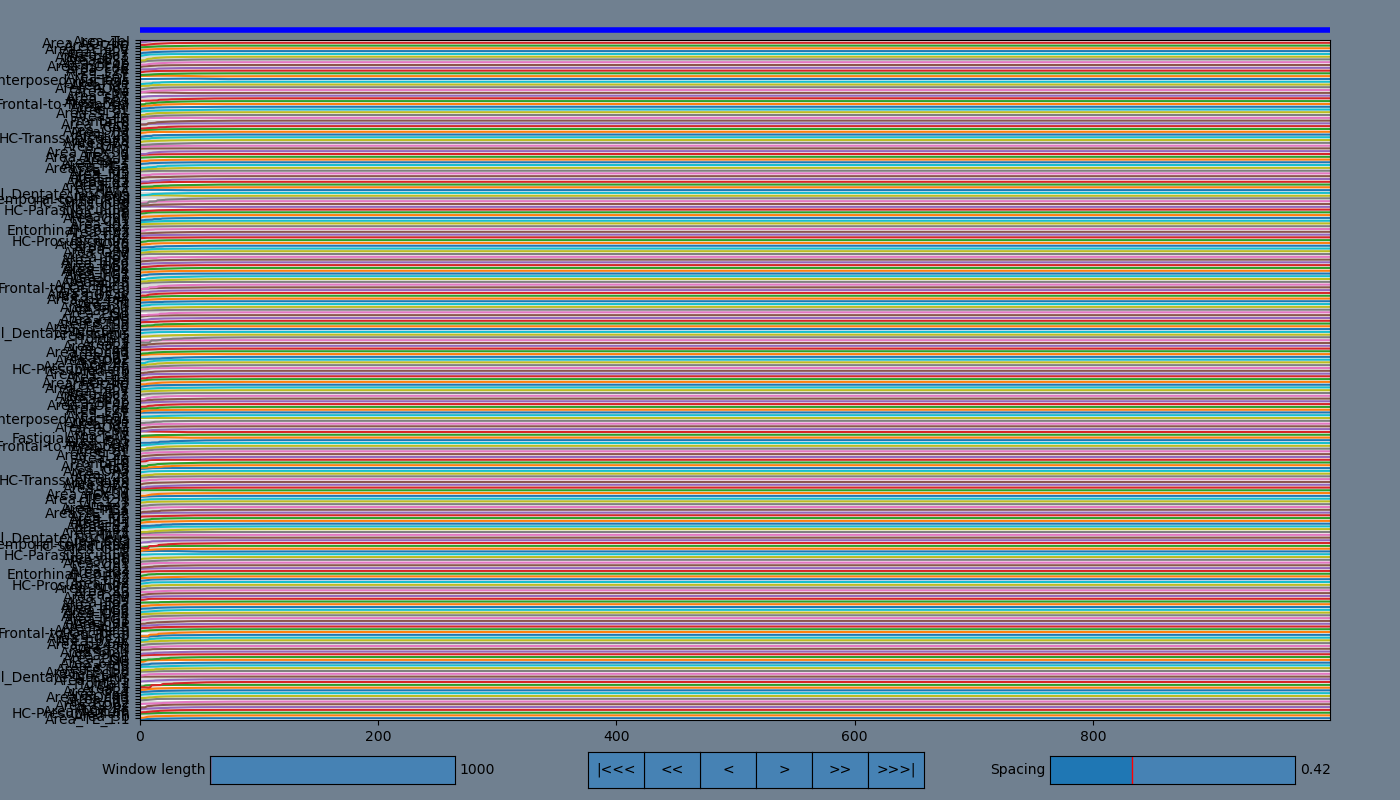

In [19]:
%pylab nbagg
import tvb.simulator.plot.timeseries_interactive as ts_int
tsi = ts_int.TimeSeriesInteractive(time_series=tsr)
tsi.configure()
tsi.show()